In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [138]:
df = pd.read_csv("/content/weather_forecast_data.csv")

In [139]:
print("Dataset Info:")
print(df.info())
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2500 non-null   float64
 1   Humidity     2500 non-null   float64
 2   Wind_Speed   2500 non-null   float64
 3   Cloud_Cover  2500 non-null   float64
 4   Pressure     2500 non-null   float64
 5   Rain         2500 non-null   object 
dtypes: float64(5), object(1)
memory usage: 117.3+ KB
None


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [140]:
print(df.isnull().sum())

Temperature    0
Humidity       0
Wind_Speed     0
Cloud_Cover    0
Pressure       0
Rain           0
dtype: int64


In [141]:
duplicates = df.duplicated().sum()

In [142]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers capped")

    df[col] = df[col].clip(lower=lower, upper=upper)

Temperature: 0 outliers capped
Humidity: 0 outliers capped
Wind_Speed: 0 outliers capped
Cloud_Cover: 0 outliers capped
Pressure: 0 outliers capped


In [143]:
target_column = "Rain"


In [144]:
# Encode categorical variables
X = df.drop(columns=[target_column])
y = df[target_column]

for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

if y.dtype == 'object':
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)


In [145]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
# Train model
tree = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10)
tree.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

In [147]:
print("Training Accuracy:", tree.score(X_train, y_train))
print("Testing Accuracy:", tree.score(X_test, y_test))


Training Accuracy: 1.0
Testing Accuracy: 1.0


In [148]:
y_pred = tree.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       443
           1       1.00      1.00      1.00        57

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



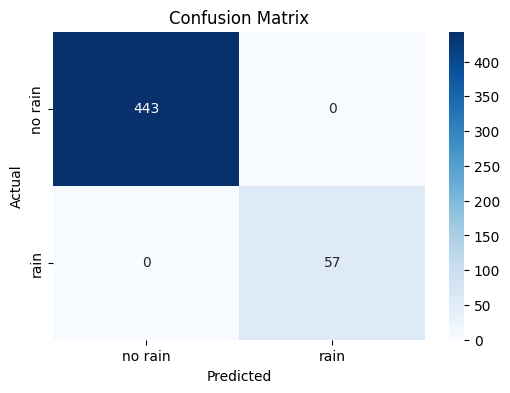

In [149]:


# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: class names
class_names = ['no rain', 'rain']

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


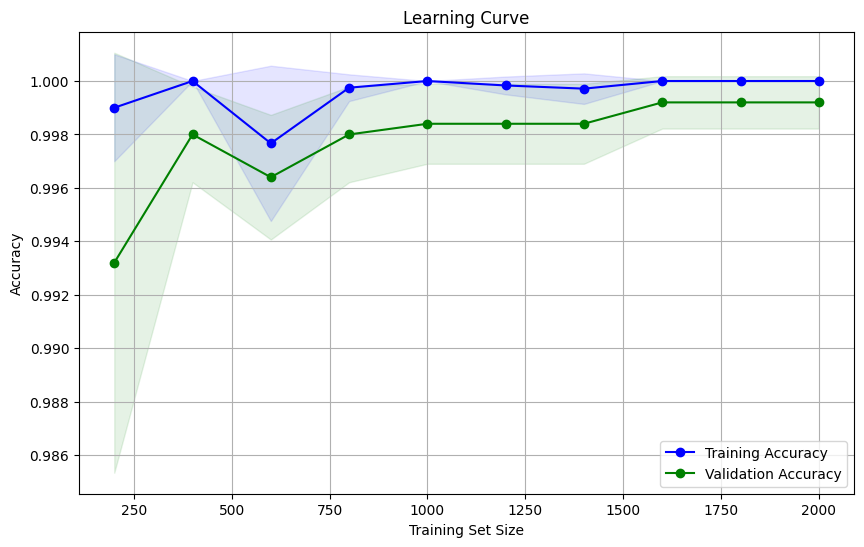

In [150]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    tree, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

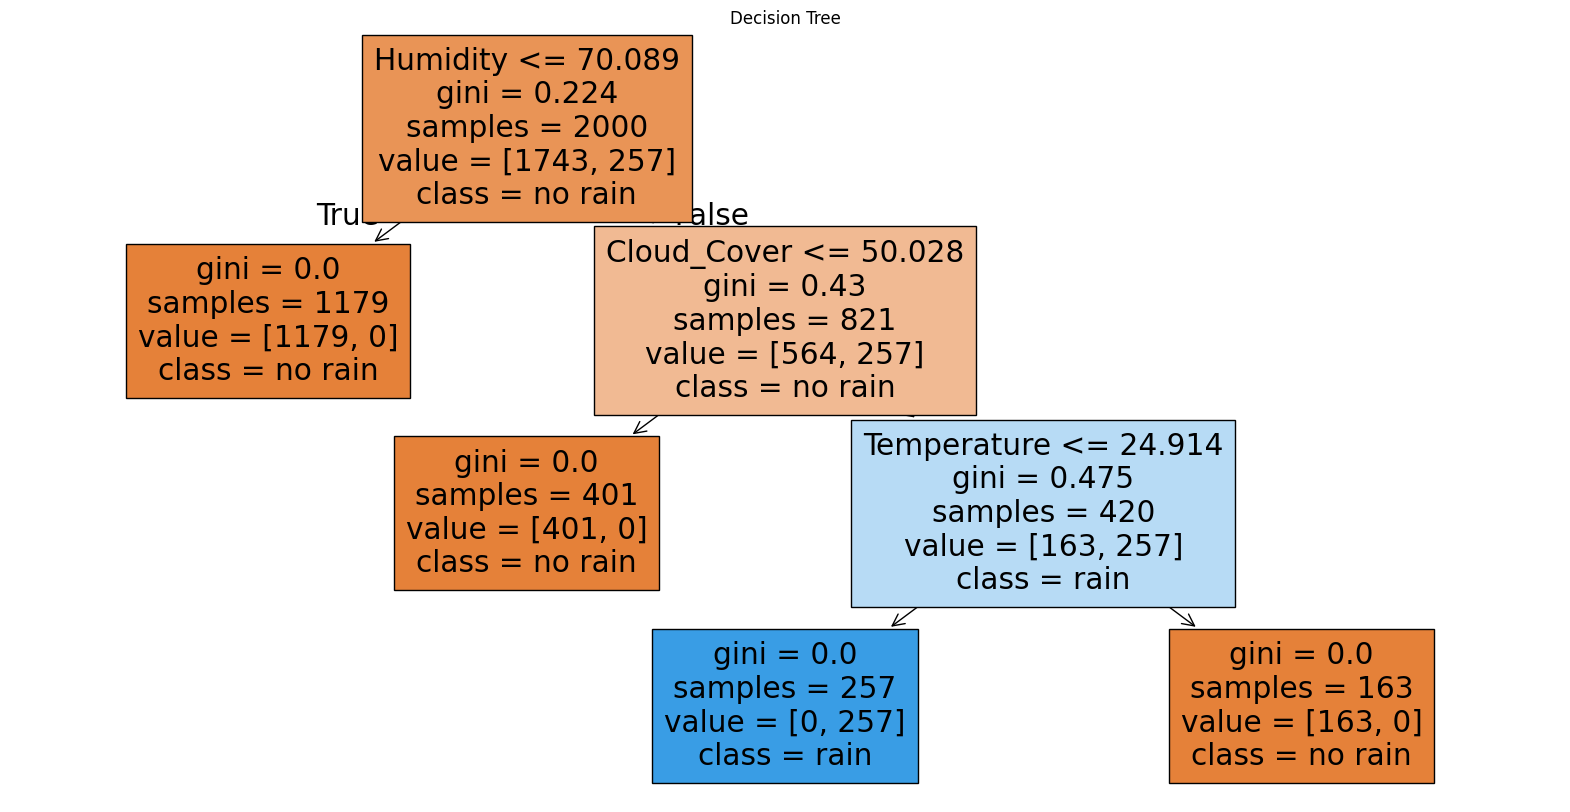

In [151]:

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, class_names=['no rain', 'rain'], filled=True)
plt.title("Decision Tree")
plt.show()

In [152]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [153]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Objective function for Optuna (no cross-validation)
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return 1.0 - accuracy  # Optuna minimizes

# 🔍 Run the search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# 📊 Show results
print("✅ Best Parameters:", study.best_params)
print("✅ Best Accuracy:", 1.0 - study.best_value)


[I 2025-07-24 11:56:00,014] A new study created in memory with name: no-name-835a8694-bb86-4bb4-8465-e0c555bee4f5
[I 2025-07-24 11:56:00,034] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-07-24 11:56:00,056] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-07-24 11:56:00,079] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2025-07-24 11:56:00,094] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2025-07-24 11:56:00,109] Trial 4 finished with value: 0.0 and parameters: {'max_depth': 1

✅ Best Parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}
✅ Best Accuracy: 1.0


In [154]:
models = {
'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=17, min_samples_leaf=9, criterion='entropy', random_state=42)
,
    'Logistic Regression': LogisticRegression(C=0.01, penalty='l2', max_iter=1000),
    'SVM': SVC(kernel='rbf', C=100000,gamma=0.0001)
}



In [155]:
  for name, model in models.items():
    print(f"\n----- {name} -----")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Training Accuracy:", model.score(X_train, y_train))
    print("Testing Accuracy:", model.score(X_test, y_test))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


----- Decision Tree -----
Training Accuracy: 1.0
Testing Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       443
           1       1.00      1.00      1.00        57

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


----- Logistic Regression -----
Training Accuracy: 0.93
Testing Accuracy: 0.932

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       443
           1       0.73      0.63      0.68        57

    accuracy                           0.93       500
   macro avg       0.84      0.80      0.82       500
weighted avg       0.93      0.93      0.93       500


----- SVM -----
Training Accuracy: 0.9995
Testing Accuracy: 0.984

Classification Report:
               precision    recall  f1-score   suppo